# Аннотация изображений

Аннотировать изображения будем в формате ограничивающих рамок (bounding boxes) в формате, пригодном для обучения нейросетей на базе фреймворка **Pytorch** (т.е. для весов `.pt` и классов `.yaml`).

В качестве основного инструмента аннотирования предлагается использовать автоматическую аннотацию на базе большой и тяжелой нейронной сети **Grounding DINO**. 

Несмотря на то, что такой подход обладает очевидными недостатками в виде больших погрешностей построения ограничивающих рамок и ограниченными возможностями самих аннотаций, все же аннотирование большого датасета (~ 1000 изображений) займет большое количество времени, которое можно было бы потратить на разработку.

## Устанавливаем зависимости

Нам нужна библиотека autodistill (для аннотирования), roboflow (для обучения) и supervision (для графики).

**ВАЖНО:** Autodistill это библиотека, использующая большие, медленные модели для обучения маленьких и быстрых. Каждую модель можно найти на GitHub и/или загрузить через пакетный менджер `pip`.

In [29]:
!pip install -q autodistill autodistill-grounded-sam autodistill-yolov8 roboflow supervision==0.9.0


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


**ВАЖНО:** Для того, чтобы было проще взаимодействовать с данными, изображениями и моделями объявим переменную `HOME`.

In [30]:
import os
HOME = os.getcwd()
print(HOME)

/Users/comrademashkov/Desktop/dev/itt/lostarmour/server/..


## Подготовка датасета

**ВАЖНО:** Для того, чтобы использовать библиотеку Autodistill нам необходимо создать папку с изображениями, которые мы хотим аннотировать и использовать для обучения целевой нейросети.

In [32]:
IMAGE_DIR_PATH = f"{HOME}/images"

In [33]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 94


In [18]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

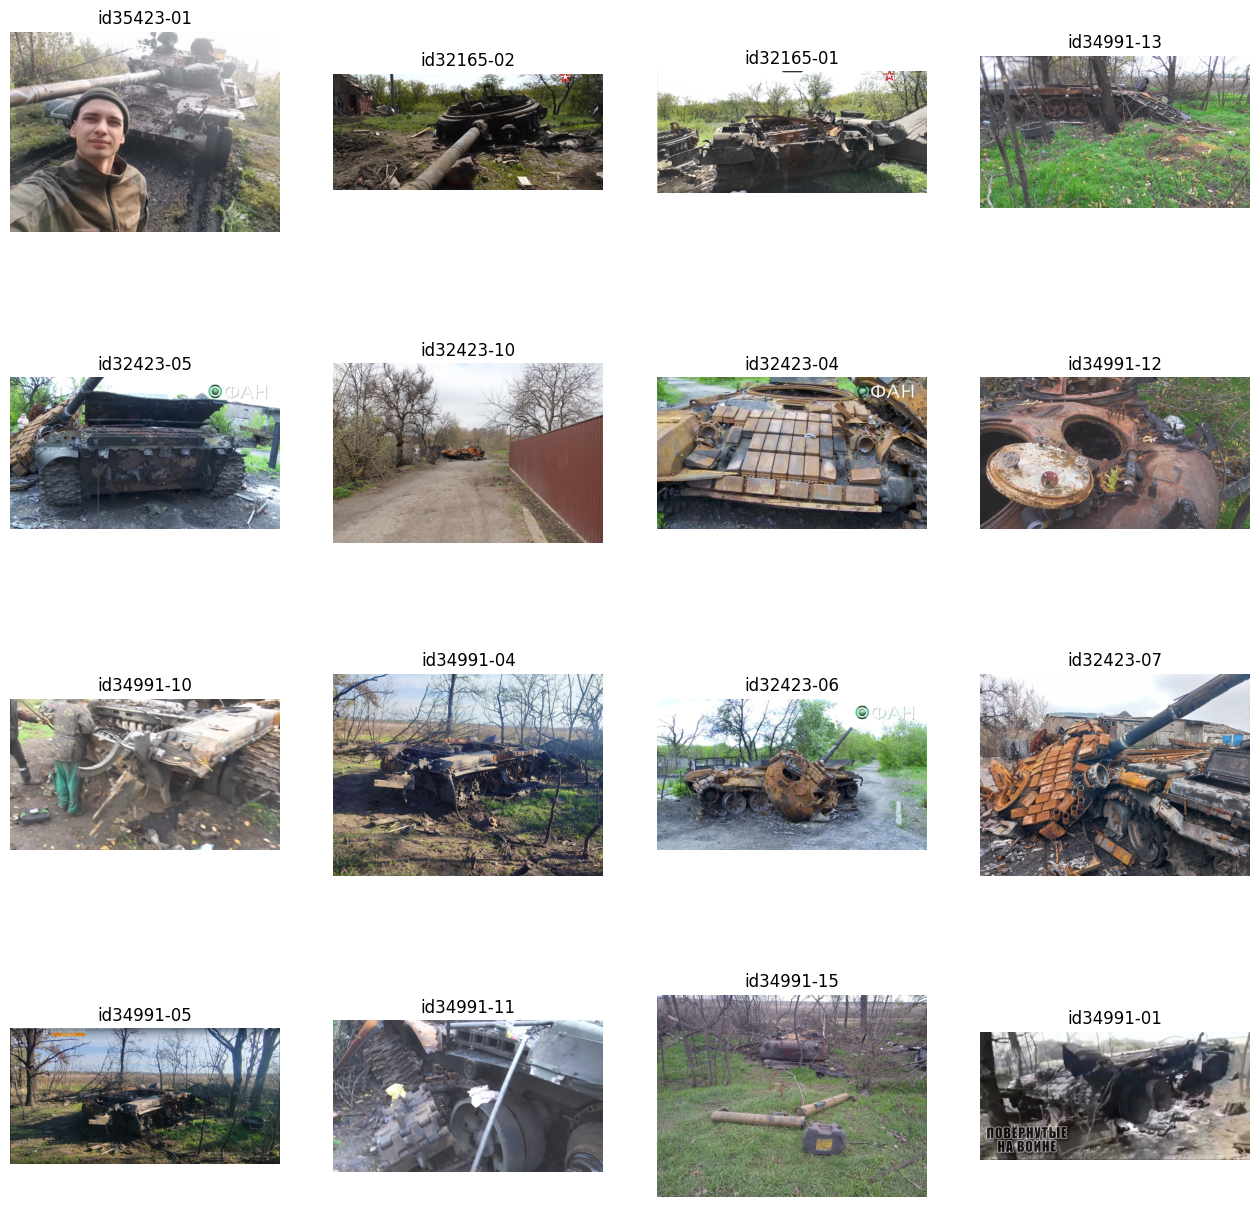

In [19]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

In [20]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "tank": "tank"
})

In [22]:
DATASET_DIR_PATH = f"{HOME}/dataset"

In [23]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Labeling /Users/comrademashkov/Desktop/dev/itt/lostarmour/src/../images/id35423-01.jpg:   0%|          | 0/47 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling /Users/comrademashkov/Desktop/dev/itt/lostarmour/src/../images/id32545-04.jpg: 100%|██████████| 47/47 [27:45<00:00, 35.43s/it]


Labeled dataset created - ready for distillation.


In [25]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [26]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

37

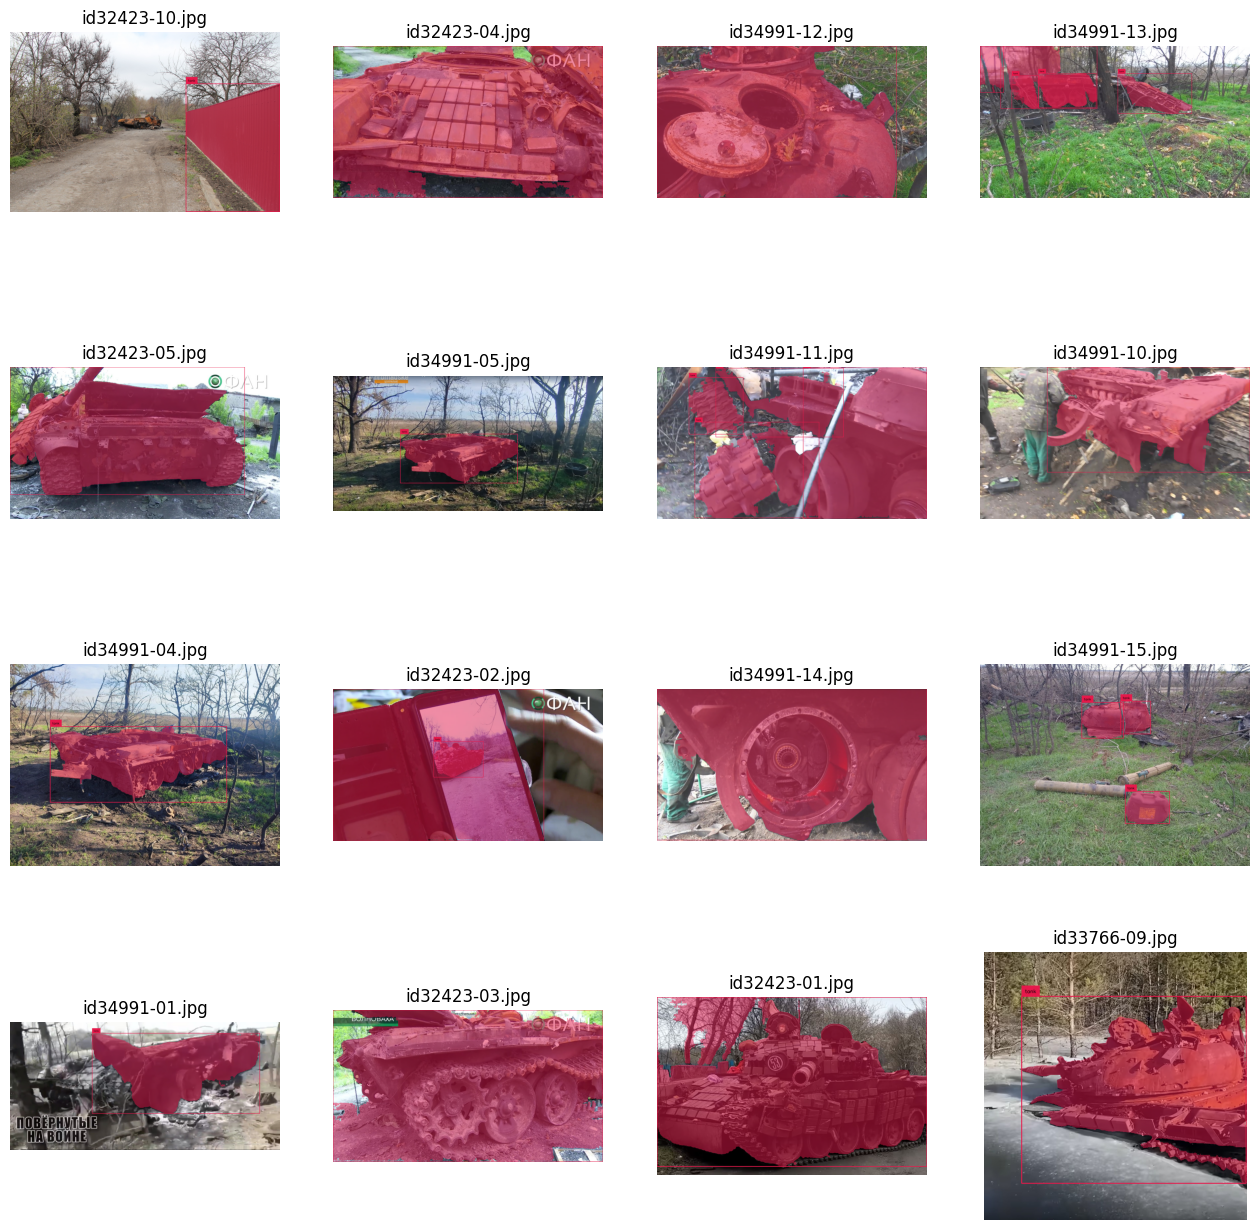

In [27]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [28]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=50)

This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.


[Errno 2] No such file or directory: '{HOME/..}'
/Users/comrademashkov/Desktop/dev/itt/lostarmour/src


WARNING ⚠️ Ultralytics settings reset to defaults. This is normal and may be due to a recent ultralytics package update, but may have overwritten previous settings. 
View and update settings with 'yolo settings' or at '/Users/comrademashkov/Library/Application Support/Ultralytics/settings.yaml'
100%|██████████| 6.23M/6.23M [00:01<00:00, 4.35MB/s]
New https://pypi.org/project/ultralytics/8.2.50 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.11.0 torch-2.3.1 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/comrademashkov/Desktop/dev/itt/lostarmour/src/../dataset/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, ma